In [1]:
from Phi import Extractor_CLIP, Phi
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.autograd import Variable

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from torchvision import transforms

from Generate_data_augmentation import *

from wilds.datasets.waterbirds_dataset import WaterbirdsDataset
from wilds.datasets.wilds_dataset import WILDSSubset

from PIL import Image

cuda = True if torch.cuda.is_available() else False

import warnings

In [2]:
z_hidden = 5
dataset_name = "waterbirds"
# dataset_name = "waterbirds_autoLF"

In [3]:
extractor_model = Extractor_CLIP(z_hidden)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.2.self_attn.q_proj.weight', 'text_model.encoder.layers.4.mlp.fc1.bias', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.3.mlp.fc2.bias', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.6.self_attn.v_proj.bias', 'text_model.encoder.layers.6.mlp.fc1.weight', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.3.mlp.fc1.bias', 'text_model.encoder.layers.9.mlp.fc2.weight', 'text_model.encoder.layers.9.self_attn.out_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.5.self_attn.q_proj.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.9.self_attn.q_proj.weight', 'text_model.encoder.layers.8.self_attn.out_proj.bias', 'text_model.encoder.layers.1.layer_norm1.bias', 'text_model.encoder.layers.7

In [8]:
batch_size = 128
# root_dir = "/home/wilds_data/"
root_dir = "./data/ready/th0.5ps25wc4"
reshape_size = (224, 224)

In [9]:
class CustomWaterbirds(WaterbirdsDataset):
    def __init__(self, **dataset_kwargs):
        super().__init__(split_scheme ='official', **dataset_kwargs)
    
    def get_input(self, idx):
        img_path = os.path.join(self.data_dir, self._input_array[idx])
        img = Image.open(img_path).convert("RGB")
        label = self._y_array.numpy()[idx]
        return img, label
    
    def get_subset(self, split, frac=1.0, transform=None):
        if split not in self.split_dict:
            raise ValueError(f"Split {split} not found in dataset's split_dict.")

        split_mask = self.split_array == self.split_dict[split]
        split_idx = np.where(split_mask)[0]

        if frac < 1.0:
            # Randomly sample a fraction of the split
            num_to_retain = int(np.round(float(len(split_idx)) * frac))
            split_idx = np.sort(np.random.permutation(split_idx)[:num_to_retain])

        return WILDSSubset(self, split_idx, transform, do_transform_y=True)


In [10]:
dataset=CustomWaterbirds(download=False, root_dir=root_dir)

FileNotFoundError: The waterbirds dataset could not be found in ./data/ready/5ps50wc10/waterbirds_v1.0. Initialize the dataset with download=True to download the dataset. If you are using the example script, run with --download. This might take some time for large datasets.

In [ ]:
dataset_orig = get_dataset(dataset=dataset_name, download=False, root_dir=root_dir)

In [7]:
dataset_orig.__dict__

NameError: name 'dataset_orig' is not defined

In [8]:
categories_map_file = os.path.join(root_dir, f"{dataset_name}_v1.0", "metadata.csv")
categories = pd.read_csv(categories_map_file)
categories.sample(5)

FileNotFoundError: [Errno 2] File b'./waterbirds_v1.0/metadata.csv' does not exist: b'./waterbirds_v1.0/metadata.csv'

In [ ]:
categories.groupby('split').count()

,img_id,img_filename,y,place,place_filename
split,,,,,
0,4795,4795,4795,4795,4795
1,1199,1199,1199,1199,1199
2,5794,5794,5794,5794,5794


In [52]:
labels = np.unique(categories['y'].tolist())
labels

array([0, 1])

In [53]:
class MyCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, tar):
        for i, t in enumerate(self.transforms):
            try:
                if t._get_name() == "Custom":
                    img = t(img, tar)
                else:
                    img = t(img[0])
            except Exception as e:
                img = t(img)
        return img, tar

In [54]:
def get_train_dataloader(transform):
    dataset_ = dataset.get_subset(split="train", transform=transform)
    return dataset_, DataLoader(dataset_, batch_size=batch_size,
                        shuffle=False)

In [55]:
# rotation_mapping = generate_transformation_mapping(labels, angles)
# trainloader_rotation = get_train_dataloader(
#     MyCompose(
#         [transforms.Resize((448, 448)), Rotate_Image(rotation_mapping), transforms.ToTensor()]
#     ))

# zoom_mapping = generate_transformation_mapping(labels, zoom_factors)
# trainloader_zoom = get_train_dataloader(
#     MyCompose(
#         [transforms.Resize((448, 448)), Zoom_Image(zoom_mapping), transforms.ToTensor()]
#     ),)

# shift_mapping = generate_transformation_mapping(labels, shift_factors)
# trainloader_shift = get_train_dataloader(MyCompose(
#         [transforms.Resize((448, 448)), Shift_Image(shift_mapping), transforms.ToTensor()]
#     ),)

traindata_orig = dataset_orig.get_subset(split="train", transform=transforms.Compose(
        [transforms.Resize(reshape_size), transforms.ToTensor()]))
trainloader_orig = DataLoader(traindata_orig, batch_size=batch_size,
                        shuffle=False)

In [56]:
segment_dataset, trainloader_segment = get_train_dataloader(
    MyCompose(
        [transforms.Resize(reshape_size), Segment_Image(), transforms.ToTensor()]
    ),)

In [57]:
# store_dir = os.path.join("/hdd2", "dyah", "waterbirds_by_dependence", "high")
# if not os.path.isdir(store_dir):
#     os.makedirs(store_dir)

In [58]:
def store_selected_samples(dataset, idxs_to_store):
    assert idxs_to_store is not None and len(idxs_to_store) > 0
    file_prefix = store_dir.split("/")[-1]
    for i, idx_ in tqdm(enumerate(idxs_to_store)):
        img = dataset[idx_][0].permute(1,2,0).detach().cpu().numpy()
#         print(os.path.join(store_dir, f"{file_prefix}_{i}.png"))
        plt.imsave(os.path.join(store_dir, f"{file_prefix}est_{i}_{idx_}.png"), img)

In [59]:
# store_selected_samples(segment_dataset,idx_to_show)

In [60]:
idx_to_show = np.random.choice(np.arange(0,200),3)
idx_to_show

array([ 30, 114, 136])

In [61]:
def show_selected_samples(dataset, rows=len(idx_to_show), title=None):
#     print(cols)
    assert idx_to_show is not None and len(idx_to_show) > 0
    fig, axs = plt.subplots(rows, 1, figsize=(6,8), constrained_layout=True)
    col_idx = 0
    row_idx = 0
    for idx_ in idx_to_show:
        img = dataset[idx_][0]
        axs[row_idx].imshow(img.permute(1,2,0))
        axs[row_idx].set_xticks([])
        axs[row_idx].set_yticks([])
        row_idx += 1
#         if row_idx == len(idx_to_show)//2:
#             row_idx +=1
#             col_idx = 0
    
    plt.tight_layout()
    if title:
        plt.savefig(f"paper_figs/{title}.png")
    plt.show()

/home/dyah/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/dyah/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


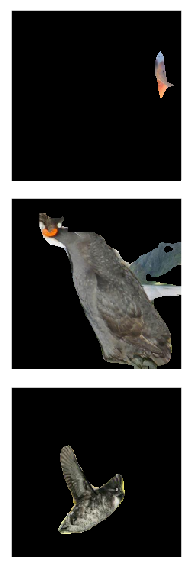

In [62]:
show_selected_samples(segment_dataset, title="segment")

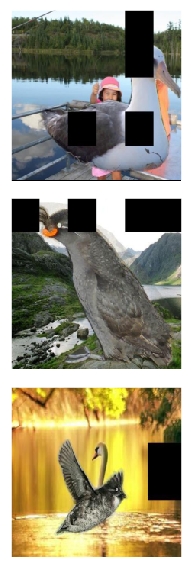

In [63]:
show_selected_samples(traindata_orig, title="orig")

In [64]:
segment2_dataset, trainloader_segment_2 = get_train_dataloader(
    MyCompose(
        [transforms.Resize(reshape_size), Segment_Image(model='fcn'), transforms.ToTensor()]
    ),)

In [65]:
def show_samples(loader, cols=6):
    fig, axs = plt.subplots(1, cols, figsize=(10,12), constrained_layout=True)
    for batch_idx, x in enumerate(loader):
        if batch_idx > 0:
            break
        imgs, labels = x[0], x[1]
        n_images = imgs.shape[0]
        cols = 6
        axs = axs.flatten()
        random_idx = np.random.choice(np.arange(imgs.shape[0]), 6, replace=False)
        img_sample = imgs[random_idx]
        for i, ax in enumerate(axs):
            img = img_sample[i]
            axs[i].imshow(img.permute(1,2,0))
            y = labels[random_idx][i].item()
            axs[i].set_title(y, fontsize=10)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
    plt.show()

In [66]:
len(idx_to_show)

3

In [67]:
# show_samples(trainloader_orig, cols=6)

In [68]:
# show_samples(trainloader_circle, cols=6)

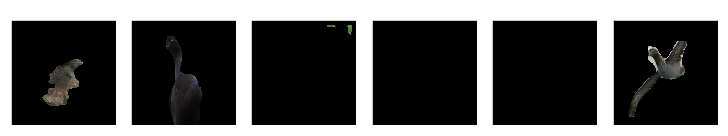

In [69]:
show_samples(trainloader_segment)

In [70]:
# show_samples(trainloader_segment_2, cols=6)

In [71]:
def extract_features(dataloader):
    phi = Phi(extractor_model)
    features = phi.get_z_features(dataloader)
    return features

In [72]:
# rotated_full, rotated_pca, rotated_mapping, rotated_components = extract_features(trainloader_rotation)
# zoom_full, zoom_pca, zoom_mapping, zoom_components = extract_features(trainloader_zoom)
# shift_full, shift_pca, shift_mapping, shift_components = extract_features(trainloader_shift)
orig_features_full, orig_features_pca, feature_mapping, components = extract_features(trainloader_orig)

38it [02:02,  3.22s/it]


In [73]:
circle_full, circle_pca, circle_mapping, circle_components = extract_features(trainloader_circle)

NameError: name 'trainloader_circle' is not defined

In [ ]:
segment_full, segment_pca, segment_mapping, segment_components = extract_features(trainloader_segment)

In [ ]:
segment_2_full, segment_2_pca, segment_2_mapping, segment_2_components = extract_features(trainloader_segment_2)

In [ ]:
test_data = dataset_orig.get_subset(
    "test",
    transform=transforms.Compose(
        [transforms.Resize(reshape_size), transforms.ToTensor()]
    ),
)
testloader = DataLoader(test_data, batch_size=batch_size,
                        shuffle=False)

In [ ]:
val_data = dataset_orig.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.Resize(reshape_size), transforms.ToTensor()]
    ),
)
valloader = DataLoader(val_data, batch_size=batch_size,
                        shuffle=False)

In [ ]:
def get_metadata(loader):
    metadata_all = []
    for i, (_, _, metadata) in tqdm(enumerate(loader)):
        metadata_all.append(metadata)
    metadata_all = np.vstack(metadata_all)
    return metadata_all

In [ ]:
train_metadata = get_metadata(trainloader_orig)

38it [00:08,  4.41it/s]


In [ ]:
store_features(train_metadata, "train", "metadata")

In [ ]:
test_metadata = get_metadata(testloader)

In [ ]:
val_metadata = get_metadata(valloader)

In [ ]:
test_features_full, tes_features_pca, _, _ = extract_features(testloader)

In [ ]:
val_features_full, val_features_pca, _, _ = extract_features(valloader)

In [88]:
suffix = "CLIP"
store_path = os.path.join("artifacts", "extracted_features", dataset_name, f"{suffix}", f"{len(labels)}_class_FA_CLEAN")
if not os.path.isdir(store_path):
    os.makedirs(store_path)

In [92]:
import pickle

def store_mapping(mapping, task=None):
    filepath = os.path.join(store_path,f'pca_feature_mapping_{task}_{z_hidden}.pickle')
    with open(filepath, 'wb') as handle:
        pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
store_mapping(ef[2], "auto")

In [ ]:
store_mapping(feature_mapping, "orig")

NameError: name 'feature_mapping' is not defined

In [ ]:
# store_mapping(rotation_mapping, "rotation")
# store_mapping(zoom_mapping, "zoom")
# store_mapping(shift_mapping, "shift")
# store_mapping(circle_mapping, "circle")

In [ ]:
store_mapping(segment_mapping, "segment")

In [ ]:
store_mapping(segment_2_mapping, "segment_2")

In [87]:
def store_features(features, mode, type_):
    if "components" in type_ or "metadata" in type_:
        np.save(os.path.join(store_path,f"{type_}_{mode}.npy"), features)
    else:
        np.save(os.path.join(store_path,f"{type_}_{mode}_{features.shape[1]}.npy"), features)

In [90]:
ef[1].shape

(4795, 6)

In [91]:
# ef=extract_features(trainloader_segment)
# store_path = ''
store_features(ef[0], 'train', 'auto_full')
store_features(ef[1], 'train', 'auto_pca')

In [ ]:
# store_features(rotated_full, "train","rotation_full")
# store_features(rotated_pca, "train","rotation_pca")
# store_features(zoom_full, "train","zoom_full")
# store_features(zoom_pca, "train","zoom_pca")
# store_features(shift_full, "train","shift_full")
# store_features(shift_pca, "train","shift_pca")
# store_features(circle_full, "train","circle_full")
# store_features(circle_pca, "train","circle_pca")
store_features(orig_features_full, "train","orig_full")
store_features(orig_features_pca, "train","orig_pca")

In [ ]:
store_features(segment_full, "train","segment_full")
store_features(segment_pca, "train","segment_pca")

In [ ]:
store_features(segment_2_full, "train","segment_2_full")
store_features(segment_2_pca, "train","segment_2_pca")

In [ ]:
store_features(test_features_full, "test", "orig_full")
store_features(tes_features_pca, "test", "orig_pca")

In [ ]:
store_features(val_features_full, "val", "orig_full")
store_features(val_features_pca, "val", "orig_pca")

In [ ]:
store_features(val_metadata, "val", "metadata")

In [ ]:
store_features(test_metadata, "test", "metadata")

In [ ]:
store_features(components, "train", "orig_components")
# store_features(rotated_components, "train", "rotation_components")
# store_features(zoom_components, "train", "zoom_components")
# store_features(shift_components, "train", "shift_components")
# store_features(circle_components, "train", "circle_components")

In [ ]:
store_features(segment_components, "train", "segment_components")

In [ ]:
store_features(segment_2_components, "train", "segment_2_components")

In [ ]:
store_path